In [8]:
import os
import math
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.metrics import roc_curve
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from statistics import median

In [2]:
IMAGE_SIZE = 100

In [3]:
dataset = []
for folder in os.listdir('./256_ObjectCategories'):
    label = os.path.split(folder)[1].split('.')[0]
    for image in os.listdir('./256_ObjectCategories/'+folder):
        d = {}
        d['label'] = int(label)
        d['image'] = cv2.resize(cv2.imread('./256_ObjectCategories/'+folder+'/'+image, 0), (IMAGE_SIZE, IMAGE_SIZE)).flatten()
        dataset.append(d)

In [21]:
xtrain = [d['image'] for d in dataset]
ytrain = [d['label'] for d in dataset]
xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, test_size=0.3, shuffle=True)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.3, shuffle=True)

In [22]:
with open("./checkpoints/bnb_model.pkl", 'rb') as file:
    clf = pickle.load(file)

In [ ]:
clf.fit(xtrain, ytrain)

In [23]:
clf.score(xtest, ytest)

0.05139932483937711

In [24]:
plk_filename = "./checkpoints/bnb_model.pkl"
with open(plk_filename, 'wb') as file:
    pickle.dump(clf, file)

In [25]:
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
ytest = tf.one_hot(np.array(ytest), 257).numpy()
yout = tf.one_hot(clf.predict(xtest), 257).numpy()
for i in range(0, 256):
    fpr[i], tpr[i], thresholds[i] = roc_curve(ytest[:,i], yout[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/home/jordan/.conda/envs/tensorflow-gpu/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


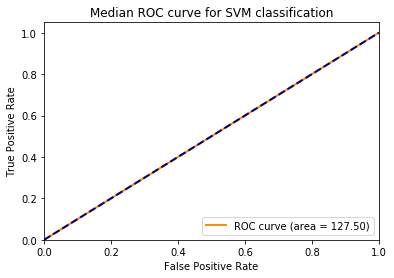

In [26]:
roc_av = roc_auc
roc_av = median(roc_av)
plt.figure()
plt.plot(fpr[100], tpr[100], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_av)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Median ROC curve for SVM classification')
plt.legend(loc="lower right")
plt.show()

In [27]:
fpr["micro"], tpr["micro"], _ = roc_curve(ytest.ravel(), yout.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/home/jordan/.conda/envs/tensorflow-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':
No handles with labels found to put in legend.


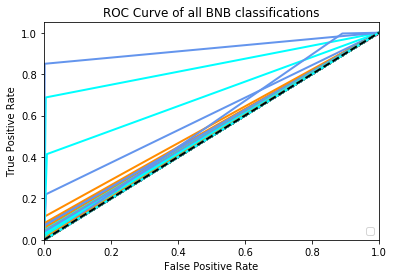

In [28]:
n_classes = 256
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of all BNB classifications')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()